# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [22]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))

dog_files   = np.array(glob("/data/dog_images/*/*/*"))
# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))
print('dog :',dog_files[110])

There are 13233 total human images.
There are 8351 total dog images.
dog : /data/dog_images/train/055.Curly-coated_retriever/Curly-coated_retriever_03883.jpg


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [23]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
print(human_files[0])
print('shape :',img.shape)
print()

/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg
shape : (250, 250, 3)



Number of faces detected: 1


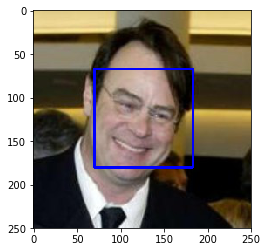

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [25]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img   = cv2.imread(img_path)
    gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [5]:
human_files_short = human_files[:100]
dog_files_short   = dog_files[:100]
count = 0
for i in range(0,100):
    if face_detector(human_files_short[i]):
        count += 1
print('% Human images detected out of 100 are: {}%'.format(100*count/100))
count =0
for i in range(0,100):
    if face_detector(dog_files_short[i]):
        count += 1
print("% Dog images than have human's deteced out of 100 are: {}%".format(100*count/100))

% Human images detected out of 100 are: 98.0%
% Dog images than have human's deteced out of 100 are: 17.0%


In [7]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short   = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
count=0
print('*** Performance of the face_detector when applied to human images  ')
t=tqdm(range(100))
for i in t:
    if face_detector(human_files_short[i]):
        #print('i is  now: {}'.format(i))
        count += 1
t.clear()
print('% Human images detected out of 100 are: {}%'.format(100*count/100),'\n')
t=tqdm(range(100))
count=0
print('\n*** Performance of the face_detector when applied to dog images  ')
for i in t:
    if face_detector(dog_files_short[i]):
        #print('i is  now: {}'.format(i))
        count += 1
t.clear()
t.refresh()
t.close()
print("% Dog images that have human's deteced out of 100 are: {}%".format(100*count/100))

  2%|▏         | 2/100 [00:00<00:06, 14.05it/s]

*** Performance of the face_detector when applied to human images  


  0%|          | 0/100 [00:00<?, ?it/s]

% Human images detected out of 100 are: 98.0% 


*** Performance of the face_detector when applied to dog images  


100%|██████████| 100/100 [01:20<00:00,  3.87it/s]

% Dog images that have human's deteced out of 100 are: 17.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [4]:
#face_dnn = cv2.dnn.readNetFromCaffe('prototxt')


In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [3]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
print(VGG16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 116945302.00it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [1]:
#
#
# Important imports!
#
import numpy             as np
import pandas            as pd
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import PIL
import matplotlib.pyplot as plt

from   torch       import nn
from   torch       import optim
from   torch       import topk
from   torchvision import datasets,models
from   PIL         import Image


#from   collections import OrderedDict


In [2]:
import os
dir=os.getcwd()
#os.chdir(dir+'/images')
print(dir)

/home/workspace/dog_project


In [3]:
#dir =os.getcwd()
#print(dir)
dir = "/data/dog_images/"
os.listdir(dir)
from pathlib import Path  #/home/workspace/dog_project/images
print(*Path(dir+'/train/').iterdir(), sep="\n")#"/home/workspace/dog_project/images/"

/data/dog_images/train/103.Mastiff
/data/dog_images/train/059.Doberman_pinscher
/data/dog_images/train/055.Curly-coated_retriever
/data/dog_images/train/031.Borzoi
/data/dog_images/train/024.Bichon_frise
/data/dog_images/train/049.Chinese_crested
/data/dog_images/train/067.Finnish_spitz
/data/dog_images/train/130.Welsh_springer_spaniel
/data/dog_images/train/019.Bedlington_terrier
/data/dog_images/train/115.Papillon
/data/dog_images/train/126.Saint_bernard
/data/dog_images/train/013.Australian_terrier
/data/dog_images/train/116.Parson_russell_terrier
/data/dog_images/train/107.Norfolk_terrier
/data/dog_images/train/133.Yorkshire_terrier
/data/dog_images/train/032.Boston_terrier
/data/dog_images/train/108.Norwegian_buhund
/data/dog_images/train/028.Bluetick_coonhound
/data/dog_images/train/066.Field_spaniel
/data/dog_images/train/129.Tibetan_mastiff
/data/dog_images/train/005.Alaskan_malamute
/data/dog_images/train/102.Manchester_terrier
/data/dog_images/train/034.Boxer
/data/dog_images

In [2]:

def pre_process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
   '''
    #image_transform = transforms.Compose([transforms.RandomRotation(180),transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()])
    image_transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()])
    input_image     = PIL.Image.open(image)
    
    #
    #
    input_image   = input_image.rotate(90)#  ***HERE***  WORKS!!
    #
    #
    
    input_image     = image_transform(input_image).float() # Switch from ints 
    nmp_arr         = np.array(input_image) 
    mean            = np.array([0.485, 0.456, 0.406]) # Same code provided by class in imshow
    std             = np.array([0.229, 0.224, 0.225]) # Same code provided by class in imshow
    
    #
    nmp_arr         = (np.transpose(nmp_arr, (1, 2, 0)) - mean)/std
    #                      code is from  Intro to ML for flower categorization: image = image.transpose((1, 2, 0))
    #                      so it is (224,224,3)--> where 3 is the color channel
    
    #print(" in process_image and transposing 1,2,0 the vector: ",arr.shape)
    
    nmp_arr         = np.transpose(nmp_arr, (2, 1, 0))
    #                     so switch it to (3,224,224) and return that:: I played with pos 1 & 0 switching
    #print(" Now switch it 2,0,1  in process_image and transposing the vector: ",arr.shape)

    return nmp_arr #returns a numpy array


In [6]:
device = 'cpu'
model  = VGG16

In [3]:
from PIL import Image

import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    input_image = pre_process_image(img_path)  #returns a numpy array
    input_image = torch.from_numpy(input_image).type(torch.FloatTensor)# convert to a PYTORCH tensor
    input_image.unsqueeze_(0)  # Transforms the input image tensor to vector row (dim=0 input) which is needed for forward operation
    input_image = input_image.to(device)# set up inputs like before for 'cpu' or 'gpu'
    
    model.eval()
   
    with torch.no_grad():# trunoff graident decent updates
        output      = model.forward(input_image) # do forward pass through the trained model for the given image
    top_probs, indices_matches = torch.topk(output, 1)#where the indices are the indices of the elements in the original input tensor.
    
    return indices_matches.cpu().numpy()[0]#None # predicted class index

In [52]:
index_image = VGG16_predict(dog_files[5230])
print(index_image)

[171]


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [4]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    index_image = VGG16_predict(img_path)
    if index_image in range(151,268 +1):
        #print('Found Dog index is: {}'.format(index_image))
        return True
    else:
        return False
    #return None # true/false

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean  = np.array([0.485, 0.456, 0.406])
    std   = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    #image = torch.rot90(image, 2, 0)

    
    ax.imshow(image)
    
    return ax

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__Please see below.

(1)Percentage of the images in human_files_short that have deteced dogs is: zero%
(2)Percentage of the images in dog_files_short that have deteced dogs is:   100%

In [22]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short   = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
count=0
print('*** Performance of the dog_detector when applied to human images  ')
t=tqdm(range(100))
for i in t:
    if dog_detector(human_files_short[i]):
        #print('i is  now: {}'.format(i))
        count += 1
t.clear()
print('Percentage of the images in human_files_short that have detected dog out of 100 are: {}%'.format(100*count/100),'\n')
t=tqdm(range(100))
count=0
print('\n*** Performance of the dog_detector when applied to dog images  ')
for i in t:
    if dog_detector(dog_files_short[i]):
        #print('i is  now: {}'.format(i))
        count += 1
t.clear()
t.refresh()
t.close()
print("Percentage of the images in dog_files_short have detected dog images out of 100 are: {}%".format(100*count/100))


  0%|          | 0/100 [00:00<?, ?it/s]

*** Performance of the dog_detector when applied to human images  



  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of the images in human_files_short that have detected dog out of 100 are: 0.0% 


*** Performance of the dog_detector when applied to dog images  


100%|██████████| 100/100 [01:21<00:00,  1.26it/s]

Percentage of the images in dog_files_short have detected dog images out of 100 are: 100.0%


In [ ]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [45]:
### (Optional) 
# define Resnet50 model
import torch
import torchvision.models as models
RESNET50 = models.resnet50(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    RESNET50 = RESNET50.cuda()
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.



[171]


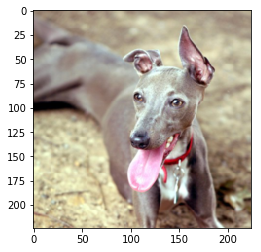

In [46]:
device = 'cpu'
model  =  RESNET50

#image_path  = dog_files[5230]
#image_path  =human_files[1900]
#index_image = dog_detector(image_path)
#print(index_image)

imshow(pre_process_image(image_path))
index_image = VGG16_predict(dog_files[5230])
print(index_image)

In [47]:
count = 0
print('*** Model is: ResNet50.  Performance of the dog_detector when applied to human images  ')
t    = tqdm(range(100))
for i in t:
    if dog_detector(human_files_short[i]):
        #print('i is  now: {}'.format(i))
        count += 1
t.clear()
print(' Model is: ResNet50.  Percentage of the images in human_files_short that have detected dog out of 100 are: {}%'.format(100*count/100),'\n')
t   = tqdm(range(100))
count=0
print('\n***  Model is: ResNet50.  Performance of the dog_detector when applied to dog images  ')
for i in t:
    if dog_detector(dog_files_short[i]):
        #print('i is  now: {}'.format(i))
        count += 1
t.clear()
t.refresh()
t.close()
print(" Model is: ResNet50. Percentage of the images in dog_files_short have detected dog images out of 100 are: {}%".format(100*count/100))

  0%|          | 0/100 [00:00<?, ?it/s]

*** Model is: ResNet50.  Performance of the dog_detector when applied to human images  


  0%|          | 0/100 [00:00<?, ?it/s]

 Model is: ResNet50.  Percentage of the images in human_files_short that have detected dog out of 100 are: 1.0% 


***  Model is: ResNet50.  Performance of the dog_detector when applied to dog images  


100%|██████████| 100/100 [00:32<00:00,  3.21it/s]

 Model is: ResNet50. Percentage of the images in dog_files_short have detected dog images out of 100 are: 99.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [6]:
#
# DATA EXPLORATION, VISUALIZATION and  PREPROCESSING
# 
    

In [2]:
#
#  This ***KSH*** Split the data set into Train, Test, and Validate
#
dog_Image_train ={}
dog_Image_test  ={}
dog_Image_valid ={}
#word=""
for idx in range(0, len(dog_files), 1): 
    pet_label = ""
    label     = []
    #
    # get pointers to get dog breeds
    #
    start_i  = str(dog_files[idx]).rfind('/')
    end_i    = str(dog_files[idx]).rfind('_')
    #
    # get pointes to mark if data is train,test, or validation
    #
    st_train = str(dog_files[idx]).find('train')
    st_test  = str(dog_files[idx]).find('test')
    st_valid = str(dog_files[idx]).find('valid')
        
    word_list_pet_image =  dog_files[idx][start_i+1:end_i].lower().split('_')
    
    for word in word_list_pet_image:
        #if word.isalpha():
        word = word + " "
        #pet_label = pet_label +" " + word        
        pet_label = pet_label + word  
    # If filename doesn't already exist in dictionary add it and it's
    # pet label - otherwise print an error message because indicates 
    # duplicate files (filenames)
    pet_label = pet_label.strip()
    if st_train   > 0:
        if dog_files[idx] not in dog_Image_train:
            dog_Image_train[dog_files[idx]] = [pet_label,label]#[pet_label]
        else:
            print("** Warning: Duplicate files exist in TRAIN directory:", dog_files[idx])
            break
    elif st_test  > 0:
        if dog_files[idx] not in dog_Image_test:
            dog_Image_test[dog_files[idx]] = [pet_label,label]
        else:
            print("** Warning: Duplicate files exist in TEST directory:", dog_files[idx])
            break
    elif st_valid > 0:
        if dog_files[idx] not in dog_Image_valid:
            dog_Image_valid[dog_files[idx]] = [pet_label,label]
        else:
            print("** Warning: Duplicate files exist in VALID directory:", dog_files[idx])
            break

In [17]:
count =0
for i in dog_Image_train:
    count +=1
    print(count,' ',i,' ',dog_Image_train[i][0])
    if count == 2:
    #    break

1   /data/dog_images/train/103.Mastiff/Mastiff_06833.jpg   mastiff
2   /data/dog_images/train/103.Mastiff/Mastiff_06826.jpg   mastiff


In [18]:
#
#    Build dog breed categories
#
dog_categories = []
count          = 0
#
# This builds the category list
#
for key in dog_Image_train:
    #dog_labels = [0]*133
    if dog_Image_train[key][0] not in dog_categories:
        dog_categories.append(dog_Image_train[key][0])
        #print(count,' ',dog_categories[count])
        #print('\n')
        count +=1

In [19]:
# NOTE:  I had thought that we were to Label the data set and built this code for that purpose. I wasted time.   
#
# DON'T NEED THIS CODE !! 
#
#
# Make lables using One-Hot-Encoding  Training  data set too!
#
#   KEEP! Use later for assigning labels to the dog images 28-Jun-2020
#
#for col in data.columns: 
#list(data.columns.values) 
from pandas import DataFrame
#
#  One-Hot-Encode the breeds 
#
df_tst               = pd.DataFrame (dog_categories,columns=['dog breeds'])
df_tst['dog breeds'] = pd.Categorical(df_tst['dog breeds'])
df_dummies           = pd.get_dummies(df_tst['dog breeds'])#,prefix='category' remove the prefix don need it
df_tst               = pd.concat([df_tst,df_dummies],axis=1)
df_tst               = df_tst.drop(['dog breeds'], axis=1)

for key in dog_Image_train:
    dog_Image_train[key][1] = np.array(df_tst[dog_Image_train[key][0]])
    #print('\n--> key -->',key,' *** Breed: ',dog_Image_train[key][0],' label:',dog_Image_train[key][1])


In [20]:
#
#    # DON'T NEED THIS CODE!! 
#
#    Make lables using One-Hot-Encoding  VALID data set!
#
for key in dog_Image_valid:
    dog_Image_valid[key][1] = np.array(df_tst[dog_Image_valid[key][0]])
    #print('\n--> key -->',key,' *** Breed: ',dog_Image_valid[key][0],' label:',dog_Image_valid[key][1])
    
        #if dog_Image_train[key][0] == col:
        #    print('Found match --> key --> {} col-name is: {}'.format(key,col))
        #    dog_Image_train[key][1] == df_tst[col]
del df_tst
del df_dummies

In [21]:
#
#    Need to do Data Exploration of dog images   
#
import cv2                
img = cv2.imread(dog_files[1010])
print(dog_files[1010])
print('shape :',img.shape)
print()
#ht, wth, channel = img.shape
ht, wth, _ = img.shape
print('Ht {}, whidth {}, Channel'.format(ht,wth))

/data/dog_images/train/034.Boxer/Boxer_02425.jpg
shape : (805, 871, 3)

Ht 805, whidth 871, Channel




Dog Image Median: Height    466.0
Width     500.0
dtype: float64  Mean: Height    532.157485
Width     571.382335
dtype: float64  Standard Deviation Height    341.626020
Width     397.480566
dtype: float64


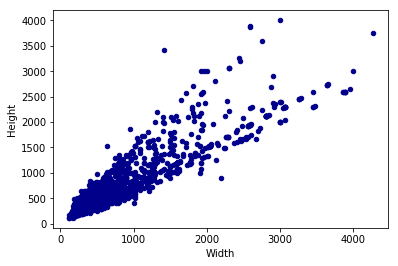

In [22]:
#
#  Graph all training Dog Image size distributions
#
img_lst =[]

for key in dog_Image_train:
    tmp_l = []
    img   = cv2.imread(key)
    ht, wth, _ = img.shape
    tmp_l.append(ht)
    tmp_l.append(wth)
    img_lst.append(tmp_l)
    
df_dog_img = DataFrame(img_lst)
Cols = ['Height', 'Width'] 
df_dog_img.columns=Cols
#df_dog_img
df_dog_img.plot.scatter(x='Width',y='Height',c='DarkBlue')
print('\n')
print('Dog Image Median: {}  Mean: {}  Standard Deviation {}'.format(df_dog_img.median(),df_dog_img.mean(),df_dog_img.std()))




Median : Height    250.0
Width     250.0
dtype: float64    Mean : Height    250.0
Width     250.0
dtype: float64   Standard Deviation Height    0.0
Width     0.0
dtype: float64


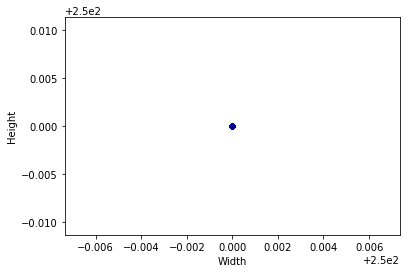

In [23]:
#
#  Graph all training Human Face Images size distributions
#
img_lst =[]

for key in human_files:
    tmp_l = []
    img   = cv2.imread(key)
    ht, wth, _ = img.shape
    tmp_l.append(ht)
    tmp_l.append(wth)
    img_lst.append(tmp_l)
    
df_human_img = DataFrame(img_lst)
Cols = ['Height', 'Width'] 
df_human_img.columns=Cols
df_human_img.plot.scatter(x='Width',y='Height',c='DarkBlue') #colormap='viridis'
print('\n')
print('Median : {}    Mean : {}   Standard Deviation {}'.format(df_human_img.median(),df_human_img.mean(),df_human_img.std()))

In [24]:
del df_human_img
del df_dog_img
del img_lst

In [26]:
#
# Create a DataFrame for more visualization and analysis
#

from pandas import DataFrame
df_train = pd.DataFrame(dict([ (k,pd.Series(v[0])) for k,v in dog_Image_train.items() ])).melt().dropna()
print(df_train.columns)
cols     = ['Dog Image','Breed']
df_train.columns =cols
print(df_train.columns)

Index(['variable', 'value'], dtype='object')
Index(['Dog Image', 'Breed'], dtype='object')


In [27]:
#
#  Group the dog breed types and count the number of images per breed in the training data set
#
count = df_train.groupby(['Breed']).count() 
print('\n\n\rThe mean for breed is:{} '.format(count.mean().round()))
print("The std for breed is:{} ".format(count.std().round()))
print('\n\n')
#print(count.describe,'\n\r')




The mean for breed is:Dog Image    50.0
dtype: float64 
The std for breed is:Dog Image    12.0
dtype: float64 






The number of Dog-images appearing in each of the 11 Ranges/Bins is : [ 3  5  9 10 11 11 15 19 24 26]
The distribution of Dog-image breeds ranges from 26.0 to 77.0 and it show IMBALANCE of the data set.
The histogram below clearly illustraites the imbalance of Dog-image distribution


(array([  3.,   5.,   9.,  10.,  11.,  11.,  15.,  19.,  24.,  26.]),
 array([ 26. ,  31.1,  36.2,  41.3,  46.4,  51.5,  56.6,  61.7,  66.8,
         71.9,  77. ]),
 <a list of 10 Patch objects>)

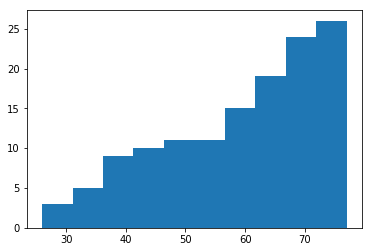

In [28]:
#
#     Build histogram of skewed distribution
#
import matplotlib.pyplot as plt
counts, bins = np.histogram(count,density=False)#Density=True
counts       = np.sort(counts)
print('\nThe number of Dog-images appearing in each of the {} Ranges/Bins is : {}'.format(len(bins),counts))
print('The distribution of Dog-image breeds ranges from {} to {} and it show IMBALANCE of the data set.'.format(min(bins),max(bins)))
print('The histogram below clearly illustraites the imbalance of Dog-image distribution')
plt.hist(bins[:-1], bins, weights=counts)



Skewness should be 0 for a Balanced data set,i.e., denotes a symmetrical distribution 
  the value of skew is negative so the skewness is an asymmetrical distribution;
  the asymmetrical distribution is toward the left side of the curve.

Skewness = :  Dog Image   -0.07762
dtype: float64

Kurtosis = :  Dog Image   -0.728101
dtype: float64

Median = :  Dog Image    50.0
dtype: float64


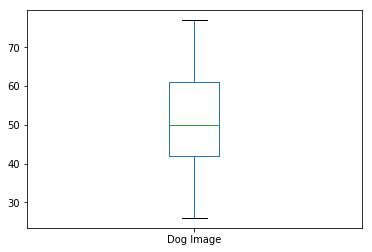

In [29]:
#
#  Determine degree of data skew
#
count.plot.box()
print('\n')
print('Skewness should be 0 for a Balanced data set,i.e., denotes a symmetrical distribution ')
print('  the value of skew is negative so the skewness is an asymmetrical distribution;')
print('  the asymmetrical distribution is toward the left side of the curve.')
skewValue=count.skew()#axis = 0, skipna = True
print('\nSkewness = : ',skewValue)
kurt = count.kurt();
print('\nKurtosis = : ',kurt)
kurt = count.kurt();
print('\nMedian = : ',count.median())


 Image Count per Dog-Breed; IMBALANCED 


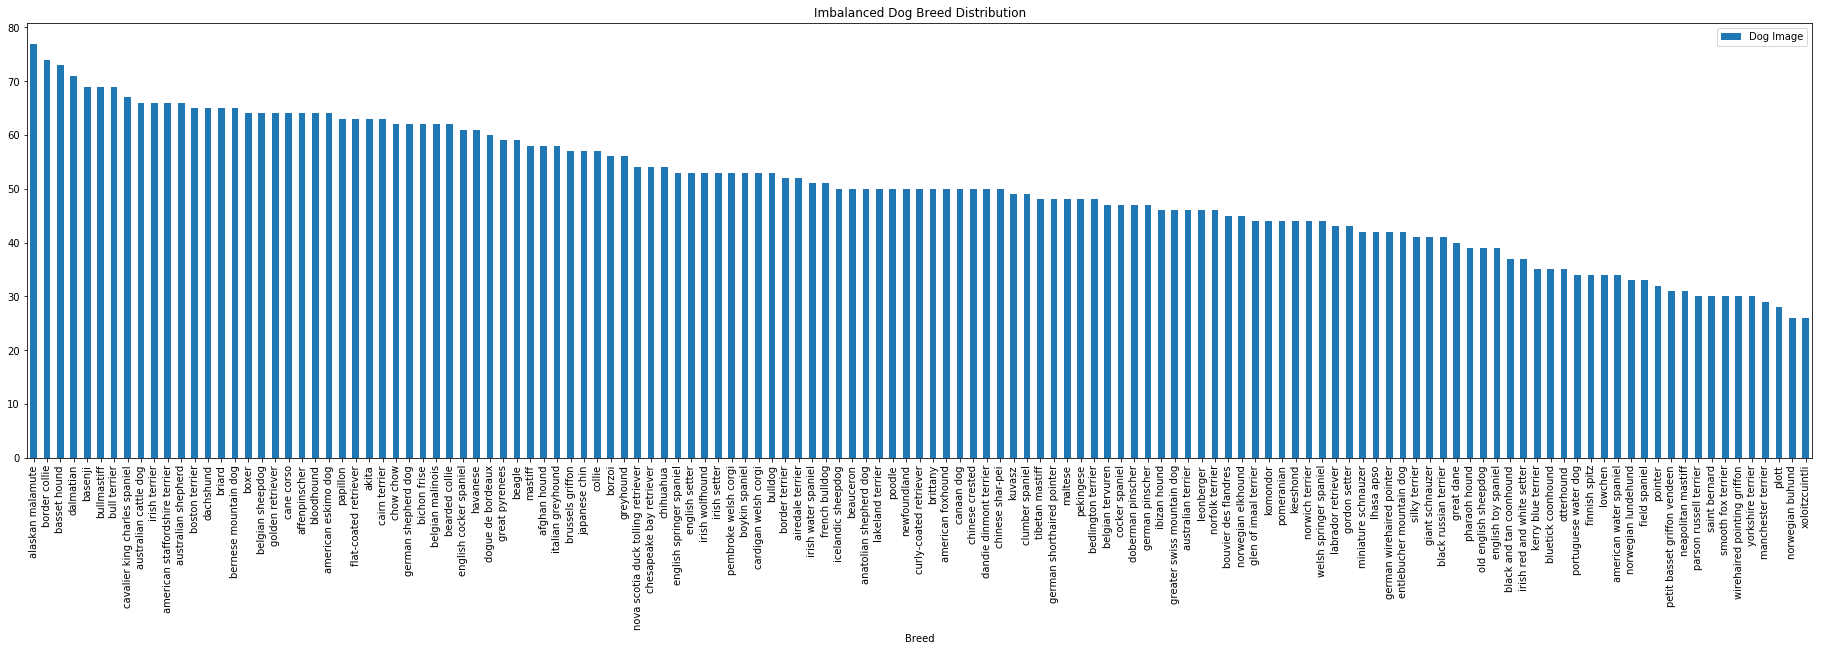

In [30]:
#
# Plot bar chart of data to show distribution of classes
#
#import matplotlib.pyplot as plt
print('\n\r Image Count per Dog-Breed; IMBALANCED ')
count.sort_values(by='Dog Image',ascending=False).plot.bar(title="Imbalanced Dog Breed Distribution",figsize=(32,8))#rot=70,


In [5]:
#
#  Set up the pointers to the directory
#
import os
from pathlib import Path  #/home/workspace/dog_project/images

data_dir   = "/data/dog_images/"
train_dir  = os.path.join(data_dir, 'train/')
valid_dir  = os.path.join(data_dir, 'valid/')
test_dir   = os.path.join(data_dir, 'test/')

#os.chdir('/home/workspace/dog_project/images/')
#os.chdir(train_dir)
#print(os.getcwd())
#print(*Path(train_dir).iterdir(), sep="\n")


In [6]:
#
#
#  set up the transfroms


from torchvision import datasets
import torch.utils.data


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),  # Test Transformation
                      transforms.CenterCrop(224),
                      transforms.ToTensor(),
                      transforms.Normalize([ 0.485, 0.456, 0.406], 
                                           [0.229, 0.224, 0.225])])




#valid_transforms = transforms.Compose([transforms.RandomRotation(30),
#                                       transforms.Resize(256),
#                                       transforms.CenterCrop(224),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.485, 0.456, 0.406], 
#                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),  # Validation Transformation       
                      transforms.CenterCrop(224),
                      transforms.ToTensor(),
                      transforms.Normalize([ 0.485, 0.456, 0.406], 
                                           [0.229, 0.224, 0.225])])

# ImageFolder applies transforms to each image within each folder.

train_data      = datasets.ImageFolder(train_dir, transform = train_transforms)
test_data       = datasets.ImageFolder(test_dir, transform = test_transforms)
valid_data      = datasets.ImageFolder(valid_dir, transform = valid_transforms)




In [7]:
#
#
#    Loaders for Training, Validation, and Test
#
import os
from torchvision import datasets
from PIL import ImageFile
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
loaders           = {}
scratch_loaders   = {}
loaders['train']  =  torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle=True,drop_last=True)#64 was the batchsize changed to 32
loaders['test']   =  torch.utils.data.DataLoader(test_data,  batch_size = 32)
loaders['valid']  =  torch.utils.data.DataLoader(valid_data, batch_size = 32)

loaders_scratch = loaders


ImageFile.LOAD_TRUNCATED_IMAGES = True
#for batch_idx, (data, target) in enumerate(loaders['train']):
#   print('Number of records read',batch_idx,' shape of data',data.shape,'shape of target',target.shape)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

Question #1

- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?

How does your code resize the images (by cropping, stretching, etc)? What size did you pick for the input tensor, and why?
(1) Training images are resized are centered-cropped to 256 pixels and center cropped to 244. To better train the model the transform is set to random rotation and horizontal flip. The mean is set to [0.485, 0.456, 0.406] and standard set to [0.229, 0.224, 0.225] from center; the images are flipped and randomly rotated. (2) Test images; To be consistent with transforms setting the test transform has a resized to 256 pixels and center crop to 224 whilst the normalization, i.e., mean of the height and width are the same as training. (3) Validation images; again for consistency, are the same configurations as for test above.

Question #2

•	Did you decide to augment the dataset? If so, how (through translations, flips, rotations, etc)? If not, why not?

(1) The dataset for training was augmented by rotation and flipping the images to better tune the training. (2) All three datasets where normalized around the mean and standard deviation vectors and are identical.


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [8]:
def set_environment(model):
    if torch.cuda.is_available():
        device ='cuda'
    else:
        device ='cpu'
    model.to(device)
    print("\n *** inside set_environment for device:-> ",device,model)

In [9]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()


In [9]:
#
#   14-AUG-20 Build CNN MODEL FROM SCRATCH lr=0.001
#
import torch.nn as nn
import torch.nn.functional as F
#
#  *** WORKED do KEEP ***  24-Jul-20  Using multiple Mentor suggestions on architecture & trial and error
#
drop_p = 0.2
# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        #
        ## Define layers of a CNN
        #
        #  Convolution layers for featrue processing & reduction
        #
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # Inital channel is 3 for RGB and start with 32 ConvFilters; a 5x5 Conv2D kernel; formula for padding results in 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # kernel_size was 5
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.drop_out = nn.Dropout(drop_p)
        
        
        self.fc1 = nn.Linear(7*7*512, 1024)  # 28*28*64 Image size sequence step down 224->112->56->28
        self.fc2 = nn.Linear(1024, 500)# 8/13--> was 113
        self.fc3 = nn.Linear(500, 133)#  8/13--> was commented out
        
        # Batch normaliztion: accelerates learning
        #
        # This removes the phenomenon of internal covariate shift, and address the problem by normalizing layer inputs.
        # The method draws its strength from making normalization a part of the model architecture and performing the
        # normalization for each training mini-batch. Batch Normalization allows one to use much higher learning rates
        # and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need 
        # for Dropout; I kept dropout rate at 20% which gave me the best quality.
        #
        self.batch_norm1 = nn.BatchNorm1d(num_features=1024)# Set to 1024  as per Fc1 to Fc2
        self.batch_norm2 = nn.BatchNorm1d(num_features=500)# Set to 500 as per Fc2 to Fc3
        
    def forward(self, out):
        #
        #  Feature processing; convolution
        #
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)  
        out = self.layer4(out)  
        out = self.layer5(out)  
        #
        #  Flatten
        #
        out = out.view(out.size(0), -1)# 
        #print('\n\n******* After  Flatten ****** >>> ',len(out),
        #      ' Type: ',type(out),' shape ',out.shape,
        #      '\n')
        
        #
        # Fully connected layers 1-2 
        #
        out = self.drop_out(out) # 
        out = self.batch_norm1(self.fc1(out)) # Batch normaliztion: accelerates learning  1024 out-features
        
        out = self.drop_out(out) # #8/13--> was commented out 
        out = self.batch_norm2(self.fc2(out)) # Batch normaliztion: accelerates learning  500 out-features 
        
        out = self.drop_out(out)
        out = self.fc3(out) #self.fc2(out)
        
        out = F.log_softmax(out, dim=1)# Needed for NLLL 23-Jul-20
        
        return out

#-----------------------------------------

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [8]:
set_environment(model_scratch)


 *** inside set_environment for device:->  cuda Net(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPoo

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

All the previous UDACITY courses that I took did not prepare me for building a CNN from scratch, in my opinion. I spent many hours reading articles on the internet and within the knowledge section of this course learning the 'what', 'how' and 'WHY' of constructing convolution layers and their processing relationship to fully connected network layers. I learned that the CNN layers are really all about feature reduction or preprocessing of the input data. Most important is securing the understanding of what each CNN layer does to the input data and how it transforms / treats input as feature reduction process producing output to the next using various 'kernel' sizes or moving-windows on each filter across the input images. Next I studied what pooling is all about (another sliding window technique) and why max-pool is the most used to literally cut the features size / Feature-Reduction down where a 2x2 max-pool filter proved optimal; max pooling is a significant filtering process within each CNN layer as is the incorporation of the activation non-linear ReLu layer. Of course, we are dealing with a two-dimensional convolution network. This entire process is known as 'Feature-Mapping'.
During this process I experimented with multiple CNN layers followed by up to four FC (Fully-Connected) layers using various kernel sizes (starting with 5). It is here that I learned all about the management of the number of kernel sizes and its relationship to the number of in_feature calculations when creating the model. In short, I was either running out of memory or the model took forever to run with poor accuracy. Noteworthy is designing the number of filters that each CNN layer had. For me this was painful. It is during the different sizing of each layers input and output layer that I realized the idea that each convolution layer's filter can be trained to search for different features in an image which is then used for CLASSIFICATION, hence feature mapping on multiple channels / filters; ended up with starting with 32. Through trial and error, I learned that I needed to start the processing with the smallest number of filters in layer one and increase them in each subsequent layer because I needed multiple trained filters to produce their own trained 2D output image as input to the next layer. Therefore, for the architecture I needed a convolution model that trained each filter to detect different features and output multiple stacked outputs. In summary I played with the following elements to arrive at the optimal architecture: (1) Kernel Size; (2) Number of filters per layer; (3) Number of convolution layers; (4) Max-Pooling was fixed because all the articles or internet examples that I studied show 2X2 is best for this application; (5) Stride, when set to one was best as the window shift parameter (which I learned also affected my in_feature size and the number of model parameter) (6) Setting the Transformations image size and crop from the center; and (7) learning rate.
I examined the input data and discerned that the images where 224X224 pixels this helped with figuring out each CNN layer output as it stepped down the image in this fashion 224->112->56->28->14->7. The ultimate training filters for each layer are 32 -> 64-> 128 -> 256 -> 512; hence five Conv2D layers.
As for the number of FC layers I went from two to three. This left me only with Dropout and Learning rate hyper-parameters to adjust. I increased the learning rate from 0.0001 to 0.001 because it takes too many epochs to reduce the validation value using the smaller number for the same results. So, three FCs with five convulsion layers coupled with the filter sizes increasing from 32 to 512 and window-size/kernel set at three with stride set to one resulted in 36% accuracy. Once attribute that increase accuracy and leaning speed was 'Batch Normalization'. This removes the phenomenon of internal covariate shift, and address the problem by normalizing layer inputs. I used this twice in the FC processing on layers FC1 and FC2 each with different number of features. This method makes normalization a part of the model architecture and performs normalization for each training batch. Batch Normalization allows for much higher learning rates and acts as a regularizes.
I set criterion_scratch to nn.NLLLoss() replacing CorssEntropy because I wanted to use the softmax feature specifically, normalizing the output between specifically, 0 and 1.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

#Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [12]:
#
#     Note: to reviewer!!
#
#  I moved around this notebook's sequence to show the scratch CNN model performance run
#  for:
##
#     (A)  25 epoch:  realized 36% Test Accuracy and a Test-Loss of 2.565
#
#  I included a graph of training v. validation to show the learning trend for 25 epochs
#
#  There are 27,841,893 total parameters to be trained in this model.
#
#

In [10]:
#
#  Finalized: 24-July-20  BUILD CNN Model from Scratch
#

import torch.optim as optim
learnR      = 0.001 #8/13--> was 0.001  #: this appears best for the 4x hidden layers that increases accuray steadily
### TODO: select loss function

criterion_scratch = nn.NLLLoss() #None...requires softmax to normilize the out put between 0 and 1
#
#                 If using NLLLoss must have in architecture  
#                 out = F.log_softmax(out, dim=1) as the final code; 23-Jul-20
#

# WORKS!! criterion_scratch = nn.CrossEntropyLoss() # 22-Jul-20 dont use softmax after last layer
### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(),learnR) # Pass ALL of the PARAMETERS to ADAM

In [7]:
#
# This Train Procedure is perfect Code 24-Jul-20 Friday
#
#  KEEP  24 - Jul -2020
#

from PIL import ImageFile

train_losses, valid_losses      = [], [] #Need for grpahing
ImageFile.LOAD_TRUNCATED_IMAGES = True

#def tst_train(n_epochs, loaders, model, optimizer, criterion, use_cuda):
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda,sav_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    
    valid_loss_min = np.Inf 
    steps          = 0
    #sav_path       = "model_scratch.pt"
    
    for epoch in range(1, n_epochs+1):        
        train_loss = 0.0
        test_loss  = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
               
        #ImageFile.LOAD_TRUNCATED_IMAGES = True

        for batch_idx, (image_data, label_target) in enumerate(loaders['train']):
            
            if use_cuda:
                image_data, label_target = image_data.cuda(), label_target.cuda()
                    
            optimizer.zero_grad()                 # clear out optimizer
            output  = model( image_data )               # train on the input image data
            loss    = criterion(output, label_target )  # Calculate loss passing the output and the labels
            
            # Backdrop and preform Adam optimization
            
            loss.backward()
            optimizer.step()                      # update the weights in the moddle for all layers

            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                      
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (image_data, label_target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                image_data, label_target = image_data.cuda(), label_target.cuda()
            ## update the average validation loss
            output = model( image_data )
            loss = criterion(output, label_target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss) 
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

         ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), sav_path)
            print("\nValidation loss {:.7f} is smaller than minimum validation loss {:.7f}".format(valid_loss, valid_loss_min))
            print("Saving the minimum validation-loss model.")
            valid_loss_min = valid_loss    
        model.train()   #16-Jul-20
        
      # return trained model
    return model

        
# train the model
# temp remove 29-Jul for transfer -> model_scratch = train(40, loaders_scratch, model_scratch, optimizer_scratch, 
#                      criterion_scratch, use_cuda, 'model_scratch.pt')
# load the model that got the best validation accuracy
# temp remove 29-Jul for transfer ->model_scratch.load_state_dict(torch.load('model_scratch.pt'))

In [55]:
#
# print out model parameters, e.g., in_features into FC1 input layer
#
# Code from Will Koehrsen Nov 26, 2018
#
total_params = sum(p.numel() for p in model_scratch.parameters())
print(f'{total_params:,} total model_scratch parameters.')
total_trainable_params = sum(
    p.numel() for p in model_scratch.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training model_scratch parameters.')

#classifier_input = model_scratch.classifier[0].in_features 
#classifier_input = model_scratch 
print(model_scratch )

27,841,893 total model_scratch parameters.
27,841,893 training model_scratch parameters.
Net(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding

In [58]:
# train the model for 25 epochs
# temp remove 29-Jul for transfer -> 
model_scratch = train(25, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
# temp remove 29-Jul for transfer ->
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 0.000660 	Validation Loss: 0.005356

Validation loss 0.0053561 is smaller than minimum validation loss inf
Saving the minimum validation-loss model.
Epoch: 2 	Training Loss: 0.000629 	Validation Loss: 0.005000

Validation loss 0.0050002 is smaller than minimum validation loss 0.0053561
Saving the minimum validation-loss model.
Epoch: 3 	Training Loss: 0.000606 	Validation Loss: 0.005082
Epoch: 4 	Training Loss: 0.000587 	Validation Loss: 0.004758

Validation loss 0.0047585 is smaller than minimum validation loss 0.0050002
Saving the minimum validation-loss model.
Epoch: 5 	Training Loss: 0.000565 	Validation Loss: 0.004832
Epoch: 6 	Training Loss: 0.000547 	Validation Loss: 0.004789
Epoch: 7 	Training Loss: 0.000526 	Validation Loss: 0.004684

Validation loss 0.0046843 is smaller than minimum validation loss 0.0047585
Saving the minimum validation-loss model.
Epoch: 8 	Training Loss: 0.000510 	Validation Loss: 0.004180

Validation loss 0.0041804 is smaller than

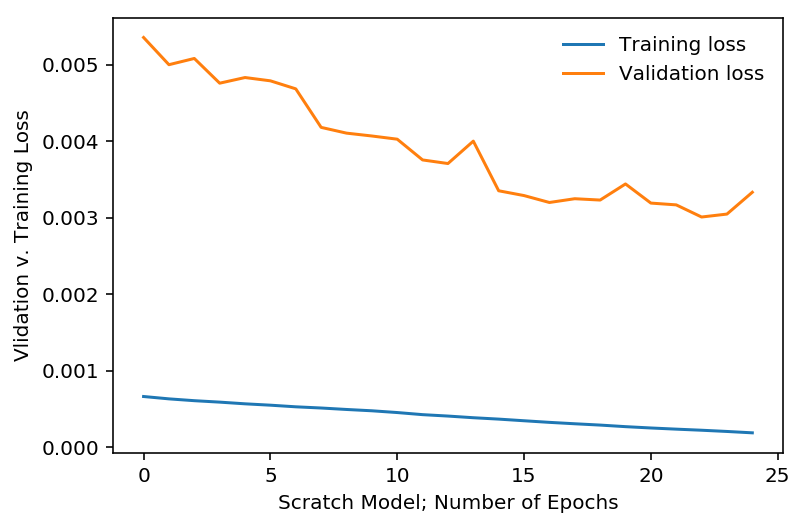

In [59]:
#
# Graph scratch model validation & training loss w.r.t. number of 20 epochs
#
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(train_losses,label = 'Training loss')
plt.plot(valid_losses,label = 'Validation loss')
plt.legend(frameon=False)
plt.xlabel('Scratch Model; Number of Epochs')
plt.ylabel('Vlidation v. Training Loss')
plt.show()

In [49]:
#
#  How to calculate total parameters traininable
#
# Code from Will Koehrsen Nov 26, 2018
#
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model_scratch.parameters())
print(f'{total_params:,} total model_scratch parameters.')
total_trainable_params = sum(
    p.numel() for p in model_scratch.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training model_scratch parameters.')
#135,335,076 total parameters.
#1,074,532 training parameters.
print(model_scratch )

27,841,893 total model_scratch parameters.
27,841,893 training model_scratch parameters.
Net(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding

In [60]:
#
# Calculate Test Loss and Accuracy for 20 Epochs.... 
#    
#
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.565951


Test Accuracy: 36% (302/836)


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [8]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
#model_scratch.load_state_dict(torch.load('model_scratch.pt'))
#test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

In [10]:
#
#
#  This section is addressing the confusion matrix for the scratch model.
#  This confusion matrix will allow me to see which categories the network is confusing with one another. 
#

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageFile

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
#from resources.plotcm import plot_confusion_matrix

In [10]:
#
# need to have a prediction tensor with a single dimension that has the same length as our training set.
# This prediction tensor will contain 133 predictions for each sample from our training data 
#    (one for each category of dog breed).
# After obtaining this tensor, use the labels tensor to generate a confusion matrix.
# The confusion matrix will show which categories the model is predicting correctly and which categories
# the model is predicting incorrectly. For the incorrect predictions the matrix will identify which categories
# are confusing the model.
len(test_data )
#len(train_data.targets)
#
# Create a DataLoader that has batch_size=1 This will pass a single batch to the network at once and will give
# the desired prediction tensor for all the training data samples.
#
#
#with torch.no_grad():
#prediction_loader = torch.utils.data.DataLoader(train_data, batch_size=32)#100
#prediction_loaders=loaders['test']#Train

#    train_preds = get_all_preds(model_scratch, prediction_loader)
    
#print(type(prediction_loader))
#ImageFile.LOAD_TRUNCATED_IMAGES = True
#for batch_idx, (data, target) in enumerate(prediction_loader):
#   print('Number of records read',batch_idx,' shape of data',data.shape,'shape of target',target.shape)

836

In [11]:
#
# Test to get lables from data loader
#
# instantiate the CNN
model_scratch = Net()
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [12]:
#
#  code from Deeplizard module on confusion matrix, modified fr this project
#
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    #print('\classes in plot is: ',type(classes),' classes =',classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
#@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    all_labels= torch.tensor([])
    
    for batch in loader:
        images, labels = batch
        if use_cuda:
            images, labels  = images.cuda(), labels.cuda()
            all_preds       = all_preds.cuda()
            all_labels      = all_labels.cuda().type(torch.FloatTensor)
            #preds                  = preds.cuda()

        preds = model(images)
        all_preds = torch.cat( (all_preds, preds) ,dim=0 )
        all_labels = torch.cat( (all_labels, labels.type(torch.FloatTensor)),dim=0)
        
        
    return all_preds , all_labels

def get_num_correct(preds, labels):
    
    if use_cuda: 
        labels =labels.type(torch.LongTensor).cuda()
       # labels=labels.type(torch.LongTensor)
    return preds.argmax(dim=1).eq(labels).sum().item()

In [13]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
with torch.no_grad():
    #prediction_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
    prediction_loaders=loaders['test']
    train_preds, test_labels = get_all_preds(model_scratch, prediction_loaders)

In [14]:
preds_correct = get_num_correct(train_preds, test_labels)#train_set.targets
print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_data)*100)#train_data

total correct: 188
accuracy: 22.48803827751196


In [15]:
cm = confusion_matrix(test_labels, train_preds.argmax(dim=1))
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[0, 0, 0, ..., 0, 0, 1],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 3, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Confusion matrix, without normalization
[[0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 2 0 0]
 [0 0 0 ..., 0 3 0]
 [0 0 0 ..., 0 0 0]]


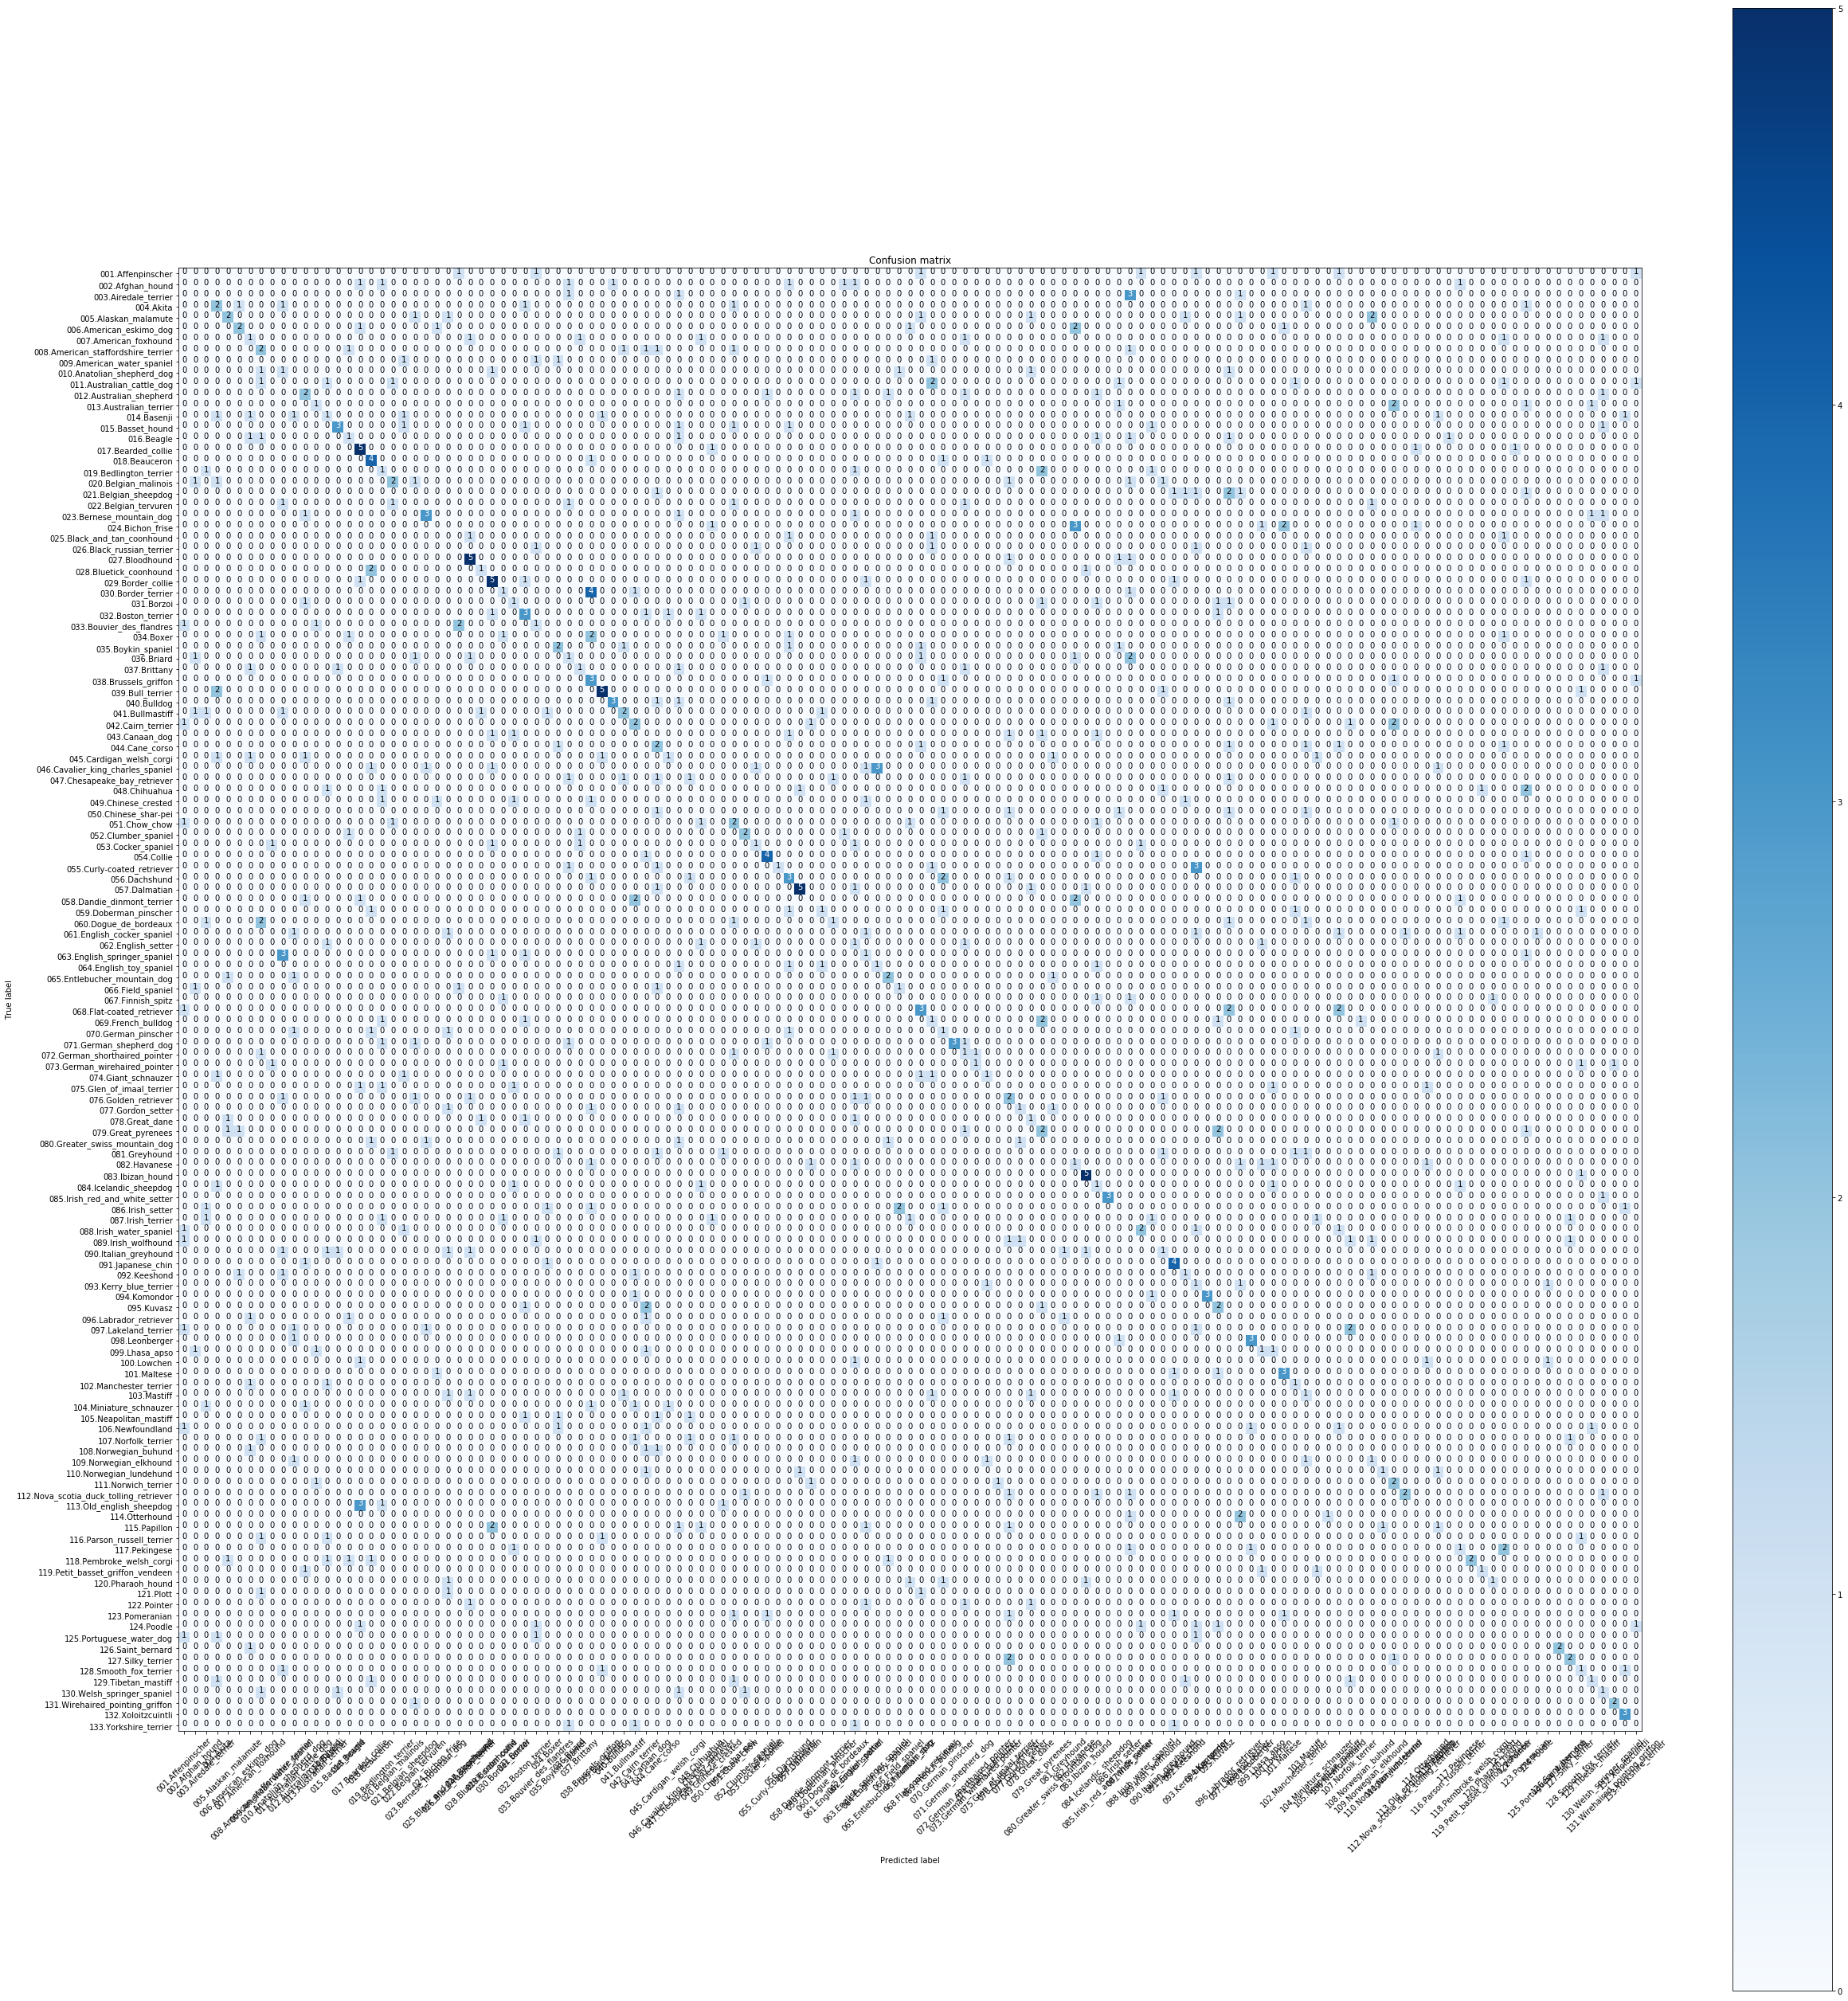

In [15]:
plt.figure(figsize=(35,35))
plot_confusion_matrix(cm, test_data.classes)#train_data.classes

In [16]:
FP = cm.sum(axis=0) #- np.diag(cm) 
FN = cm.sum(axis=1) #- np.diag(cm)
print('FP:',FP,len(FP))
print('FN:',FN,len(FN))
TP = np.diag(cm)
print('TP on diagognal:',TP,len(TP))
TN = (cm.sum() - (FP + FN + TP))
print('TN :',TN,len(TN))

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
#    Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
#    Specificity or true negative rate
TNR = TN/(TN+FP) 
#    Precision or positive predictive value
PPV = TP/(TP+FP)
#    Negative predictive value
NPV = TN/(TN+FN)
#    Fall out or false positive rate
FPR = FP/(FP+TN)
#    False negative rate
FNR = FN/(TP+FN)
#   False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)


print('\nSensitivity / or true positive rate for each class=:\n\r ',TPR)
print('\nSpecificity / true negative rate for each class=:\n\r  ',TNR)
print('\nPercision / positive predictive value for each class=:\n\r  ',PPV)
#print('\nNegative predictive value =: ',NPV)
#print('Fall out or false positive rate =: ',FPR)
#print('False negative rate =: ',FNR)
#print('False discovery rate =: ',FDR)
print('Accuracy for each class =:\n\r  ',ACC)

FP: [ 9  5  6 11  6  5  9 13  2 11  7  9  4  8  6  6 15 12  9  6  5  6  6  3  8
  4 12  3 13  5  6 11  7  3  7  8  4 16  9  4  6 10 10 13  3 12  4  6  3  3
 11  5  4  8  1 12  7  3  3  3  2 13  8  5  5  4  5 10 10 10  3 10  2  4  1
 14  3  6 10  3  2  9  9 10  3  6 14  5  4  6 10  5 12  3  9 12  7  5  5  6
  7  6  9  3  1  7  5  1  6  2  9  3  2  3  5  1  5  2  2  2  8  1  9  1  2
  2  5  6  4  8  3  6  4] 133
FN: [ 8  8  6  8 10  8  7  8  4  6  9  9  6  9 10  8  8  7  6  8  8  6  8  8  4
  5  8  4 10  7  7  8  5  8  6  8  6  7  9  7  9  8  6  8  7  9  7  7  6  6
  8  6  6  7  7  9  9  7  6  8  8  6  7  5  5  4  4  8  7  6  8  6  5  5  5
  8  5  5  8  5  7  8  6  6  4  7  8  6  7  8  7  5  4  5  6  5  6  5  5  4
  6  3  7  5  4  6  6  3  5  4  5  7  5  4  8  4  6  7  4  5  3  4  5  6  4
  3  5  4  6  5  3  3  4] 133
TP on diagognal: [0 0 0 2 2 2 1 2 0 1 0 2 1 1 3 1 5 4 1 2 0 0 3 0 0 0 5 1 5 1 1 3 1 0 2 1 1
 3 5 3 2 2 0 2 1 0 1 0 0 0 2 2 1 4 1 3 5 0 1 1 0 1 1 1 2 1 0 3 1 1 3 1 1 1
 0 2 

In [19]:
import pandas as pd

#
# Code from:https://stats.stackexchange.com/questions/95209/how-can-i-interpret-a-confusion-matrix
#
# The diagonal elements show the number of correct classifications for each class
# The off-diagonal elements provides the misclassifications
# The total number of classifications for each class in both y_true and y_pred,
# from the "All" subtotals
# This method also works for text labels, and for a large number of samples in the
# dataset can be extended to provide percentage reports.

#
#
#the numbers now represent the percentage of the outcomes that were classified.

cm_review = pd.crosstab(test_labels, train_preds.argmax(dim=1), rownames=['True'], colnames=['Predicted'], margins=True)

cm_review

Predicted,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,128,129,130,131,132,All
True,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,8
1.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
2.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
3.0,0,0,0,2,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8
4.0,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
5.0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
6.0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,7
7.0,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,8
8.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [48]:
#
#  KSH*** Add *** a column 'classes'  cm_percent = pd etc;  cm_percent['Classes'] = test_data.classes
#
cm_percent = pd.crosstab(test_labels, train_preds.argmax(dim=1), rownames=['True'], colnames=['Predicted']).apply(lambda r: 100.0 * r/r.sum())
cm_percent['Classes'] = list(test_data.classes)

cm_percent[:][:]

#cm_percent.set_option('display.max_columns', None)
#print(cm_percent.iloc[0]['Classes'],cm_percent.iloc[0][:132])

Predicted,0,1,2,3,4,5,6,7,8,9,...,124,125,126,127,128,129,130,131,132,Classes
True,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,33.333333,001.Affenpinscher
1.0,0.0,33.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,002.Afghan_hound
2.0,0.0,0.000000,33.333333,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,003.Airedale_terrier
3.0,0.0,0.000000,0.000000,0.0,0.000000,16.666667,0.000000,7.692308,0.0,22.222222,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,004.Akita
4.0,0.0,0.000000,0.000000,0.0,28.571429,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,005.Alaskan_malamute
5.0,0.0,0.000000,0.000000,0.0,0.000000,33.333333,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,006.American_eskimo_dog
6.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,11.111111,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,18.181818,0.000000,0.000000,0.000000,007.American_foxhound
7.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,15.384615,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,008.American_staffordshire_terrier
8.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,20.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,009.American_water_spaniel


In [ ]:
# Compute the F1 score, also known as balanced F-score or F-measure
#
# The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
#
# F1 = 2 * (precision * recall) / (precision + recall)
# In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending
# on the average parameter.
#
# 'weighted':
#             Calculate metrics for each label, and find their average weighted by support 
#           (the number of true instances for each label). This alters ‘macro’ to account 
#            for label imbalance; it can result in an F-score that is not between precision and recall.
#

In [18]:
f1_score(test_labels, train_preds.argmax(dim=1), average='weighted')

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.22068443841926996

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [9]:
## TODO: Specify data loaders
#
# Reuse the very same data loaders used in the scratch CNN model
#

#
#  27-Jul-20 Monday night
#
loaders_transfer = loaders

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [10]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

#---------Not Good Enough-------------29-Aug-2020--------------------------------

#def freeze_params(model):
#    for param in model.parameters():# Freeze parameters so we don't backprop through them
#            param.requires_grad = False
drop_p = 0.3# was .5

class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.classifierT =nn.Sequential(nn.Linear(25088, 4096),#4096->1024
                           nn.ReLU(),
                           nn.Linear(4096, 1024),#added layer 1024
                           nn.ReLU(),            #added layer 1024           
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, 133),
                           nn.LogSoftmax(dim=1),
                           nn.Dropout(p=drop_p))   

    def build_classifier(self,x):
        x = self.classifierT(self)
        return x

'''
#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
model_transfer.classifier = model_scratch

if use_cuda:
    model_transfer = model_transfer.cuda()
'''

'\n#-#-# You so NOT have to modify the code below this line. #-#-#\n\n# instantiate the CNN\nmodel_scratch = Net()\nmodel_transfer.classifier = model_scratch\n\nif use_cuda:\n    model_transfer = model_transfer.cuda()\n'

In [10]:
#
# Test 9-ASep-20  Performance Increased to 79% accuracy; Too much overfitting!
#
#  lr = 0.001
#  Dropuout = 0.25
#  Test Loass 0.0726
#  Accuracy = 79%
#
#import torchvision.models as models
#import torch.nn as nn

## TODO: Specify model architecture 

#----------------------------30-Aug-2020--------------------------------
#
#
drop_p = 0.25# was .5

class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.classifierT =nn.Sequential(nn.Linear(25088, 4096),#4096->1024
                           nn.ReLU(),
                           nn.Linear(4096, 4096),#1024
                           nn.ReLU(),  
                           nn.Linear(4096, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, 133),
                           nn.LogSoftmax(dim=1),
                           nn.Dropout(p=drop_p))   

    def build_classifier(self,x):
        x = self.classifierT(self)
        return x

In [12]:
model_transfer   = models.vgg16(pretrained=True)                 #keep
classifier_input = model_transfer.classifier[0].in_features      #keep
#x=model_transfer.fc.in_features
print('Vgg16 classifier_inputs are =:',classifier_input) 


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 97573934.17it/s] 


Vgg16 classifier_inputs are =: 25088


In [25]:
#
# *** Improve model 9-Sep
#
def freeze_params(model):
    for param in model.parameters():# Freeze parameters so we don't backprop through them
            param.requires_grad = False
# Replace default classifier with new classifier
model_scratch  = Net()
model_scratch  = model_scratch.classifierT # This is necessary to access the nn.Sequential specifications

print(model_scratch)

freeze_params(model_transfer)
model_transfer.classifier = model_scratch# model_scratch.classifierT
if use_cuda:
    model_transfer = model_transfer.cuda()

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4096, out_features=4096, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4096, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=133, bias=True)
  (9): LogSoftmax()
  (10): Dropout(p=0.25)
)


In [19]:
#
# set up
#

#def freeze_params(model):
#    for param in model.parameters():# Freeze parameters so we don't backprop through them
#            param.requires_grad = False
# Replace default classifier with new classifier

model_scratch  = Net()
model_scratch  = model_scratch.classifierT # This is necessary to access the nn.Sequential specifications

print(model_scratch)

freeze_params(model_transfer)
model_transfer.classifier = model_scratch# model_scratch.classifierT
if use_cuda:
    model_transfer = model_transfer.cuda()


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4096, out_features=4096, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4096, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=133, bias=True)
  (9): LogSoftmax()
  (10): Dropout(p=0.3)
)


In [32]:
#
# TEST REMOVE
#
#model_scratch = Net()
#model_transfer.classifier = model_scratch

set_environment(model)


 *** inside set_environment for device:->  cpu VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

The process applied to determine the transfer model was to first determine which pretrained CNN model to use and replace it’s classifier with a specific model designed for dog-breed classification.  There are multiple choices to select form namely DenseNET-169, ResNet50, VGG16. The table below presents the accuracy of each mode and it is from ‘https://keras.io/api/applications/’

      MODEL	      REPORTED ACCURACY (TOP-5)
      DENSENET-169       93.2% Size = ( 57 MB)
      RESNET50	       92.1% Size = ( 98MB)
      VGG16              90.1% Size = (528 MB)

I chose the VGG16 model. I built a net NET class using the Sequential specification to design the classifier which will replace the VGG16 model classifier. The in_features where specified in the VGG16 model as 25,088. Initially, I started with 2 and 3 hidden layers which just consumed GPU resources and showed no substantial performance differences varying the input and output parameters. I went to one hidden layer and got good results, 'less is best'. So, for the final model there is one input layer, three hidden layer and the output layer. I used the NLLLoss criterion which requires the softmax normalize process to be applied after the output layer for probabilities. I decreased the Dropout to 20% from 50% to improve the training/learning process. My classifier ended up with 139,048,901 total parameters of which 124,334,213
are the training parameters.  I achieved very good results with just 20 epochs. I had to write a model 
save and load procedure to store the best model from the training procedure, where I needed to save
the newly trained classifier. In the load procedure I move the GPU tensors to CPU so I can run the next
set of exercises in CPU mode.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [23]:
#
#  How to calculate total parameters traininable
#
# Code from Will Koehrsen Nov 26, 2018
#
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model_transfer.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_transfer.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

139,048,901 total parameters.
124,334,213 training parameters.


In [26]:
import torch.optim as optim
criterion_transfer = None
optimizer_transfer = None
#
# ***KSH***  1-Aug-20  Try looking at the Net class and make sure the training parameters are set
#
learnR             = 0.0001 #:001 this appears best for the 3x hidden layers that increases accuray steadily
criterion_transfer = nn.NLLLoss() #None...requires softmax to normilize the out put between 0 and 1
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(),learnR)#optim.Adam(model_transfer.parameters(),learnR) #
#
#  The code below works when passing all the model parameters, but dont need it if I just pass the
#   model_transfer.classifier.parameters()
#
#optimizer_transfer = optim.Adam(filter(lambda p: p.requires_grad, model_transfer.parameters()),learnR)
#Regarding the optimizers;explicitly filter out the parameters that don't require grad (trivial using the filter builtin).

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [27]:
# train the model

train_losses, valid_losses      = [], [] #Need for grpahing
n_epochs = 22#35
loaders_transfer = loaders
#model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.000438 	Validation Loss: 0.001630

Validation loss 0.0016299 is smaller than minimum validation loss inf
Saving the minimum validation-loss model.
Epoch: 2 	Training Loss: 0.000168 	Validation Loss: 0.001148

Validation loss 0.0011479 is smaller than minimum validation loss 0.0016299
Saving the minimum validation-loss model.
Epoch: 3 	Training Loss: 0.000115 	Validation Loss: 0.000974

Validation loss 0.0009736 is smaller than minimum validation loss 0.0011479
Saving the minimum validation-loss model.
Epoch: 4 	Training Loss: 0.000090 	Validation Loss: 0.000944

Validation loss 0.0009440 is smaller than minimum validation loss 0.0009736
Saving the minimum validation-loss model.
Epoch: 5 	Training Loss: 0.000072 	Validation Loss: 0.000916

Validation loss 0.0009160 is smaller than minimum validation loss 0.0009440
Saving the minimum validation-loss model.
Epoch: 6 	Training Loss: 0.000063 	Validation Loss: 0.000874

Validation loss 0.0008742 is smaller than mi

In [28]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.726068


Test Accuracy: 79% (663/836)


In [31]:
#
#   Save best model
#
save_model(model_transfer, 'model_transferBEST.pt')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

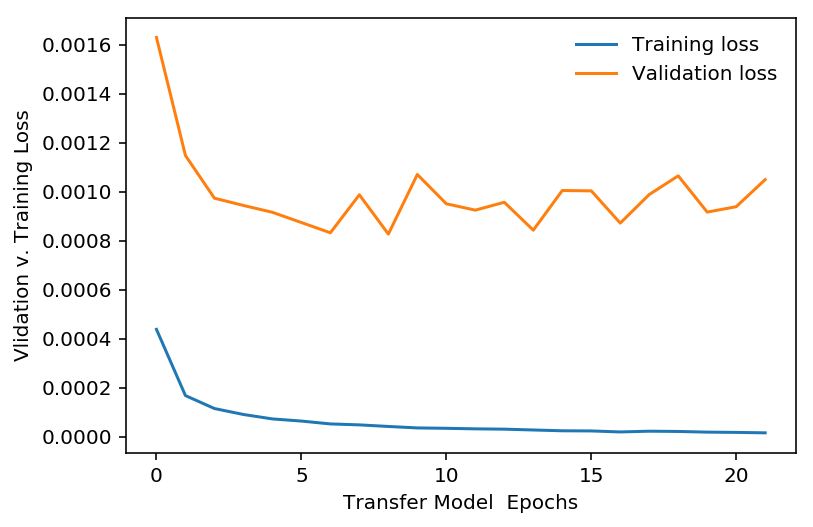

In [32]:
#
 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.plot(train_losses,label = 'Training loss')
plt.plot(valid_losses,label = 'Validation loss')
plt.legend(frameon=False)
plt.xlabel('Transfer Model  Epochs')
plt.ylabel('Vlidation v. Training Loss')
plt.show()

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [30]:
#
# 7-Aug-20 Friday  Try this code to see if I can save and recover the model
#
#  fine name will be 'model_transferBEST.pt'
#
def save_model(model, sav_path):
    model.to('cpu')
    model = model.eval()
    file_name =''
    checkpoint_dic ={'state_dict'    : model.state_dict(),
                     'classifier'    : model.classifier
                    }
    #
    #probabily best to do:  model.device('cpu')
    #                       model.eval() inference then save
    
    #print("\n\n*** Inside save model file name is: {}".format(file_name))
    
    torch.save(checkpoint_dic, sav_path)    
    return
#
# Code from train
# 
# torch.save(model.state_dict(), sav_path)

In [14]:
#
# 7-Aug-20 Friday  Try this code to see if I can save and recover the model
#
#  fine name will be 'model_transferBEST.pt'
#
def load_checkpoint(file_name):  
    #checkpoint        = torch.load(file_name)# Mentor provided so dont need gpu
    checkpoint        =  torch.load(file_name, map_location=lambda storage, location: storage)
    
    model     = models.vgg16(pretrained    =True)
    
    
    model.classifier = checkpoint['classifier']
    #set_environment(model)#!!! Not sure this works
    model.to('cpu')
    model.eval()
    #checkpoint        = torch.load(file_name)
    #freeze_params(model)

    model.load_state_dict(checkpoint['state_dict']) # 13-May
    
    freeze_params(model)
    
    return model

In [17]:
#
#  Recover the BEST run time model
#
def freeze_params(model):
    for param in model.parameters():# Freeze parameters so we don't backprop through them
            param.requires_grad = False

In [18]:
model = load_checkpoint('model_transferBEST.pt')

Indxx  :  [35] Briard  prob [[ 0.99998587]]


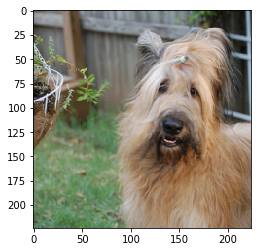

In [110]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
import torch
import torchvision.models as models
#
#
#  10-Sept-20:: Had to rewrite this code
#
#   Adding:
#     top_probs, indices_matches = torch.topk(output, 1)
#     ps = top_probs.exp()   ----> Since the criteron is NLLL I  need its inverse
#     ps = ps.cpu().numpy()
#
#print('checkpoint type',type(checkpoint),' -->',checkpoint)
'''
model.load_state_dict(torch.load('model_transfer.pt', map_location=lambda storage, location: storage))

'''
# list of class names by index, i.e. a name can be accessed like class_names[0]
#class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]
#
# -----------------------------------------------------------------------------------
#

from PIL import Image

import torchvision.transforms as transforms

def predict_breed_transfer (img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    input_image = pre_process_image(img_path)  #returns a numpy array
    input_image = torch.from_numpy(input_image).type(torch.FloatTensor)# convert to a PYTORCH tensor
    input_image.unsqueeze_(0)  # Transforms the input image tensor to vector row (dim=0 input) which is needed for forward operation
    input_image = input_image.to(device)# set up inputs like before for 'cpu' or 'gpu'
    
    model_transfer.eval()
   
    with torch.no_grad():# trunoff graident decent updates
        output      = model.forward(input_image) # do forward pass through the trained model for the given image
    top_probs, indices_matches = torch.topk(output, 1)#where the indices are the indices of the elements in the original input tensor.
    #imshow(pre_process_image(image_path))
    ps = top_probs.exp()
    ps = ps.cpu().numpy()
    return  ps, indices_matches.cpu().numpy()[0]#None # predicted class index


#for ii in class_names:
#    print('Classnames: ',ii)
device = 'cpu'
image_path  = dog_files[4219]
#image_path ="/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg"
#imshow(pre_process_image(image_path))

prob,indxx= predict_breed_transfer (image_path)
#probb=prob.numpy()
#print('probb ',probb)
print('Indxx  : ',indxx,class_names[int(indxx)],' prob',prob)#probb[0])
imshow(pre_process_image(image_path))

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.


In [131]:

## handle cases for a human face, dog, and neither
#
#
def run_app(image_path):
    if dog_detector(image_path):
        print('\n\r A dog image has been dectected')
        _,classname =predict_breed_transfer (image_path)
        classname =class_names[int(classname)]
         
        print('Predicting the breed as belonging to class : {} \n'.format(classname))
        #print('Predicting the breed as belonging to class : {} \n'.format(class_names[int(predict_breed_transfer (image_path))] ))
    
    elif face_detector(image_path):
        print('\n\r A human image has been dectected')
        _,classname =predict_breed_transfer (image_path)
        classname =class_names[int(classname)]        
        print('This human resembles a dog-breed and would belong to class : {} \n'.format(classname))
    else:
        print('\n\r **** ERROR *** invalid image submitted:')
        #imshow(pre_process_image(image_path))

returned index is: [119]

 A human image has been dectected
This human resembles a dog-breed and would belong to class : Pharaoh hound 



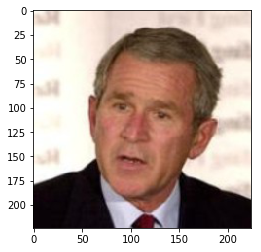

In [132]:
#
#  Test run_app
#
image_path  = human_files[6579]
run_app(image_path)
imshow(pre_process_image(image_path))


 A dog image has been dectected
Predicting the breed as belonging to class : Bedlington terrier 



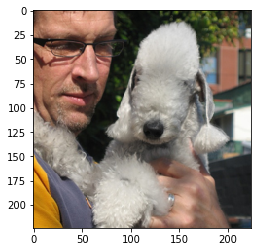

In [133]:
#
#  Test run_app
#
#
#  10-Sep-20  Dog detector had to be completely rewritten from above to include the probabilities of torch.topk 
#  to select the highest probabilites related to dog images. I selected 0.975 or greater for dog matches
#
def dog_detector(img_path):
    ## TODO: Complete the function.
    prob, index_image=predict_breed_transfer(img_path)
    if index_image in range(0,132 +1) and prob[0][0] >= 0.975:
        #print('Found Dog index is: {}  prob is: {}'.format(index_image,prob[0][0]))
        return True
    else:
        return False
    #return None # true/false

image_path  = dog_files[429]
#image_path  = human_files[55]
run_app(image_path)
imshow(pre_process_image(image_path))

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)


(1) The output is better because I expected to have some error given that the accuracy was ~79%
(2) To improve this algorithm, I would do the following changes:
    1. Experiment with the number of layers, in_features and out_features to eliminate overfitting
    2. Experiment with different Dropout regularization arounf  0.5 to fight overfitting and
       replace VGG16 with ResNet50 or DESNET-169
    3. Adjust the number of Epochs to the newly selected model.
    4. The data set for training is relatively small so I'd apply image augmentation to the data set adding:
        (a) Random noise,
        (b) Blur the image, and
        (c) Flipping the image upside down, right and left.
    5. Set the validation transform to be consistent with the training transform; I read that this improves accuracy and
       helps with converging the train and validation loss curves.

 

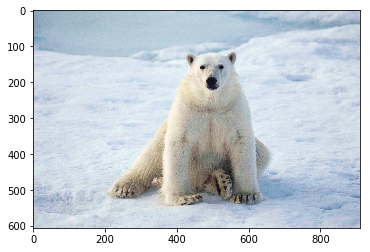


 **** ERROR *** invalid image submitted:


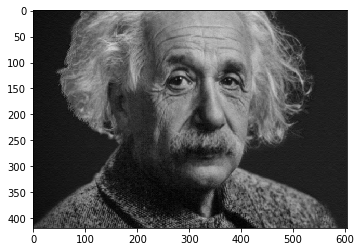


 A human image has been dectected
This human resembles a dog-breed and would belong to class : Pharaoh hound 



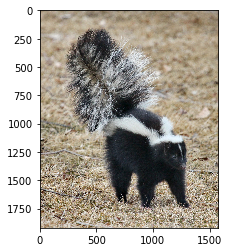


 **** ERROR *** invalid image submitted:


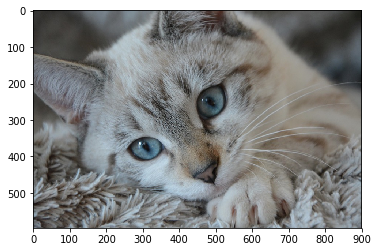


 **** ERROR *** invalid image submitted:


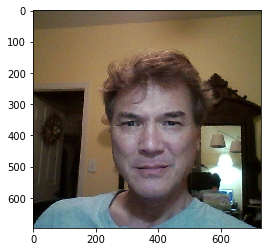


 A human image has been dectected
This human resembles a dog-breed and would belong to class : Xoloitzcuintli 



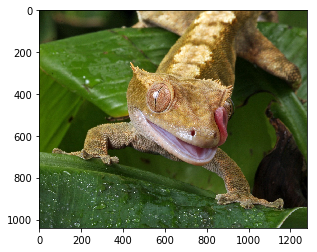


 **** ERROR *** invalid image submitted:


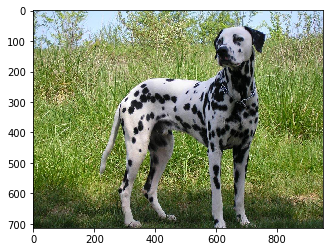


 A dog image has been dectected
Predicting the breed as belonging to class : Dalmatian 



In [134]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
import os
#import time

## suggested code, below
#for file in np.hstack((human_files[:3], dog_files[:3])):
#    run_app(file)
image_path ="/home/workspace/dog_project/uploaded_images/"
%matplotlib inline
for file in os.listdir(image_path):
    img =Image.open(image_path+file)
    plt.imshow(img)
    plt.show()
    run_app(image_path+file)
    #if imshow:
    #    run_app(image_path+file)